# Text review analysis

Apart from the ratings, users have also written their opinion about the beers. Here we want to investigate if users in different climate talk about beers differently.

First, we do the necassary imports.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import seaborn as sns
import spacy
from langdetect import detect
from tqdm import trange
import pickle


pd.set_option("display.max_columns", None)


We load the data and drop the rows where there is no text review.

In [2]:
us_users_txt_rev = pd.read_csv("data/us_users_ratings.csv", compression="gzip", usecols=["beer_id", "date", "user_id", "text", "climate"], dtype={"beer_id": "int32", "user_id": "str", "text": "str", "climate": "str"})
us_users_txt_rev = us_users_txt_rev .dropna(subset=["text"])
init_nb_rev = len(us_users_txt_rev)
print("Initial number of text reviews : ", init_nb_rev)
display(us_users_txt_rev.head())

Initial number of text reviews :  620791


,beer_id,date,user_id,text,climate
7,19827,1360753200,brewdude1982.691169,This was a 12 oz bottle poured into a snifter....,Cfa
8,19827,1357729200,agentmunky.409755,Poured from a 12 ounce bottle into a pilsner g...,Cfa
11,19827,1353150000,ferrari29.320392,Beer poured from bottle into a Nonic shaped pi...,Dfa
13,19827,1342260000,othershoe2.233642,Pours a rich brownish red with some chill haze...,Dfa
14,19827,1335607200,brentk56.6284,Appearance: These Strangford Lough beers pour ...,Cfa


Let's look at the language in which the text reviews are written.

In [3]:
lang_detect_done = True

def detect_lang(text):
    try:
        return detect(text)
    except:
        return "unknown"

if lang_detect_done:
    us_users_txt_rev = pd.read_csv("data/us_users_txt_rev_with_lang.csv", dtype={"beer_id": "int32", "user_id": "str", "text": "str", "climate": "str"})
else:
    us_users_txt_rev["language"] = us_users_txt_rev["text"].apply(lambda x: detect_lang(x))
    us_users_txt_rev.to_csv("data/us_users_txt_rev_with_lang.csv", index=False)

For simplicity, we will only keep the english reviews.

In [4]:
us_users_txt_rev = us_users_txt_rev[us_users_txt_rev["language"]=='en']
english_nb_rev = len(us_users_txt_rev)
print("Number of english text reviews : ", english_nb_rev)
print("Percentage of text reviews kept : ", round(english_nb_rev/init_nb_rev*100, 2), "%")

Number of english text reviews :  618645
Percentage of text reviews kept :  99.65 %


Now let's look at the distribution of the text reviews amongst the different climate groups.

<Axes: title={'center': 'Number of reviews per climate'}, xlabel='climate'>

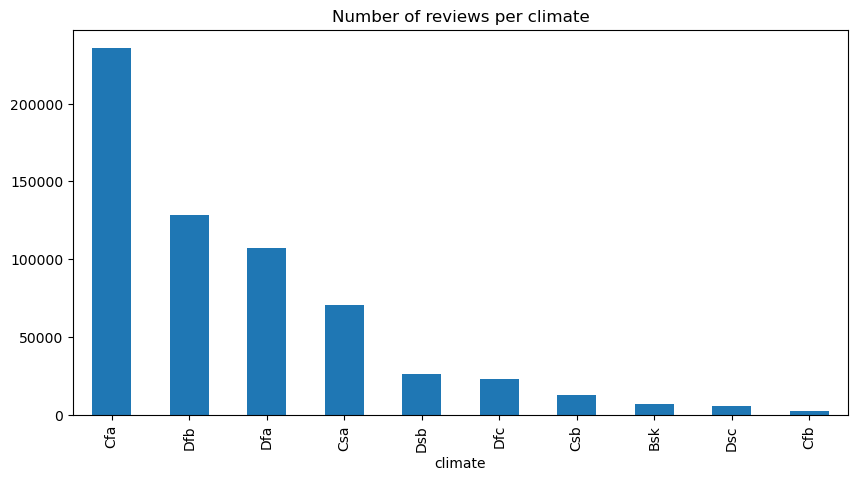

In [5]:
us_users_txt_rev.groupby("climate").count()["beer_id"].sort_values(ascending=False).plot(kind="bar", figsize=(10, 5), title="Number of reviews per climate")

Here we see that the datasets is very imbalanced with very few reviews for some climates and a huge amount for others. For this reason, we will regroup the climates in the subgroups that the three leters of the classification represent.
We add the columns to discriminate the climates on their overall scheme, seasonal precipitation and heat level.

In [6]:
climate_classifications = pd.read_csv("data/climate_classified.csv") 

#merge climate classifications with reviews
us_users_txt_rev = us_users_txt_rev.merge(climate_classifications, on="climate", how="left")

us_users_txt_rev.head()

,beer_id,date,user_id,text,climate,language,scheme,seasonal_precipitation,heat_level
0,19827,1360753200,brewdude1982.691169,This was a 12 oz bottle poured into a snifter....,Cfa,en,Temperate,without dry season,hot summer
1,19827,1357729200,agentmunky.409755,Poured from a 12 ounce bottle into a pilsner g...,Cfa,en,Temperate,without dry season,hot summer
2,19827,1353150000,ferrari29.320392,Beer poured from bottle into a Nonic shaped pi...,Dfa,en,Continental,without dry season,hot summer
3,19827,1342260000,othershoe2.233642,Pours a rich brownish red with some chill haze...,Dfa,en,Continental,without dry season,hot summer
4,19827,1335607200,brentk56.6284,Appearance: These Strangford Lough beers pour ...,Cfa,en,Temperate,without dry season,hot summer


<Axes: xlabel='heat_level'>

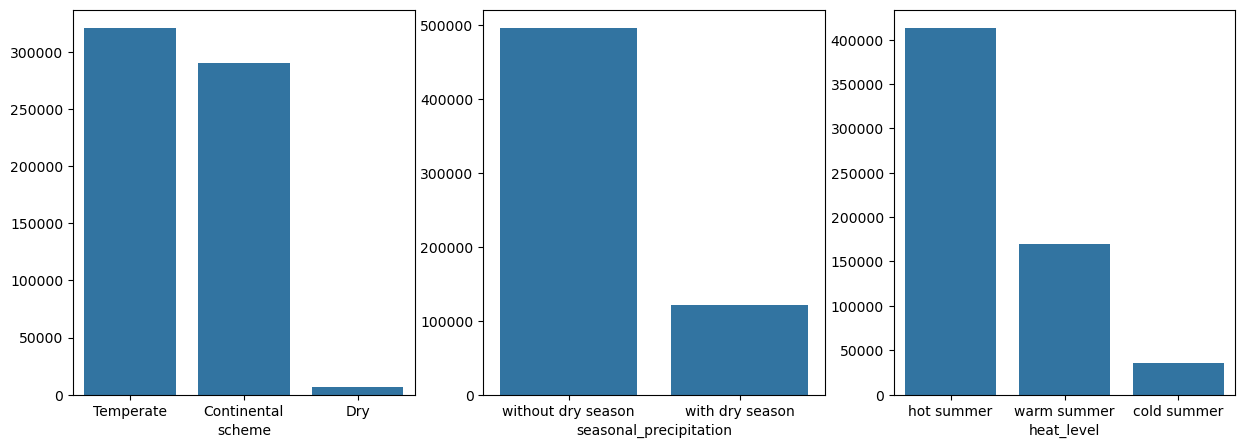

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

climate_scheme_count = us_users_txt_rev.groupby("scheme").count()["beer_id"].sort_values(ascending=False)
sns.barplot(x=climate_scheme_count.index, y=climate_scheme_count.values, ax=axs[0])

climate_precipitation_count = us_users_txt_rev.groupby("seasonal_precipitation").count()["beer_id"].sort_values(ascending=False)
sns.barplot(x=climate_precipitation_count.index, y=climate_precipitation_count.values, ax=axs[1])

climate_temperature_count = us_users_txt_rev.groupby("heat_level").count()["beer_id"].sort_values(ascending=False)
sns.barplot(x=climate_temperature_count.index, y=climate_temperature_count.values, ax=axs[2])


Let's see if there is difference in what words people use to describe beers in function of the climate they live in.

In [8]:
adj_processed = True

if adj_processed:
    with open("data/us_users_txt_rev_adj_processed.csv", "rb") as f:
        us_users_txt_rev = pickle.load(f)
else :
    #load nlp model
    nlp = spacy.load("en_core_web_sm")
    adj = [[]]*len(us_users_txt_rev)

    for i in trange(len(us_users_txt_rev)):
        doc = nlp(us_users_txt_rev["text"].iloc[i])
        adj[i] = [token.text for token in doc if token.pos_ == "ADJ"]

    us_users_txt_rev["adj"] = adj
    
    with open("data/us_users_txt_rev_adj_processed.csv", "wb") as f:
        pickle.dump(us_users_txt_rev, f)

In [9]:
us_users_txt_rev.head()

,beer_id,date,user_id,text,climate,language,scheme,seasonal_precipitation,heat_level,adj
0,19827,1360753200,brewdude1982.691169,This was a 12 oz bottle poured into a snifter....,Cfa,en,Temperate,without dry season,hot summer,"[dark, transparent, frothy, mild, low, best, a..."
1,19827,1357729200,agentmunky.409755,Poured from a 12 ounce bottle into a pilsner g...,Cfa,en,Temperate,without dry season,hot summer,"[creamy, clear, dark, Rich, brown, Slight, dry..."
2,19827,1353150000,ferrari29.320392,Beer poured from bottle into a Nonic shaped pi...,Dfa,en,Continental,without dry season,hot summer,"[Nonic, shaped, dark, brownish, colored, dark,..."
3,19827,1342260000,othershoe2.233642,Pours a rich brownish red with some chill haze...,Dfa,en,Continental,without dry season,hot summer,"[rich, brownish, big, white, little, bitter, b..."
4,19827,1335607200,brentk56.6284,Appearance: These Strangford Lough beers pour ...,Cfa,en,Temperate,without dry season,hot summer,"[clear, impressive, nice, huge, diacetyl, eart..."


In [10]:
climates = us_users_txt_rev["climate"].unique()

adj_climate_done = True

if adj_climate_done:
    with open("data/counts_climate.csv", "rb") as f:
        counts_climate = pickle.load(f)
    with open("data/adj_climate.csv", "rb") as f:
        adj_climate = pickle.load(f)
else:
    #group adjectives by climate
    adj_climate = [[]]*len(climates)
    for i in range(len(climates)):
        us_users_txt_rev_climate = us_users_txt_rev[us_users_txt_rev["climate"]==climates[i]]
        for j in trange(len(us_users_txt_rev_climate)):       
            adj_climate[i] = adj_climate[i] + us_users_txt_rev_climate["adj"].iloc[j]
        for j in trange(len(adj_climate[i])):
            adj_climate[i][j] = adj_climate[i][j].lower()

    #counts for each words
    counts_climate = [pd.Series(adj_climate[i]).value_counts() for i in range(len(adj_climate))]

    with open("data/counts_climate.csv", "wb") as f:
        pickle.dump(counts_climate, f)
    with open("data/adj_climate.csv", "wb") as f:
        pickle.dump(adj_climate, f)

 25%|██▍       | 58119/235574 [12:37<1:16:57, 38.43it/s]

In [ ]:
with open("data/counts_climate.csv", "wb") as f:
    pickle.dump(counts_climate, f)
with open("data/adj_climate.csv", "wb") as f:
    pickle.dump(adj_climate, f)

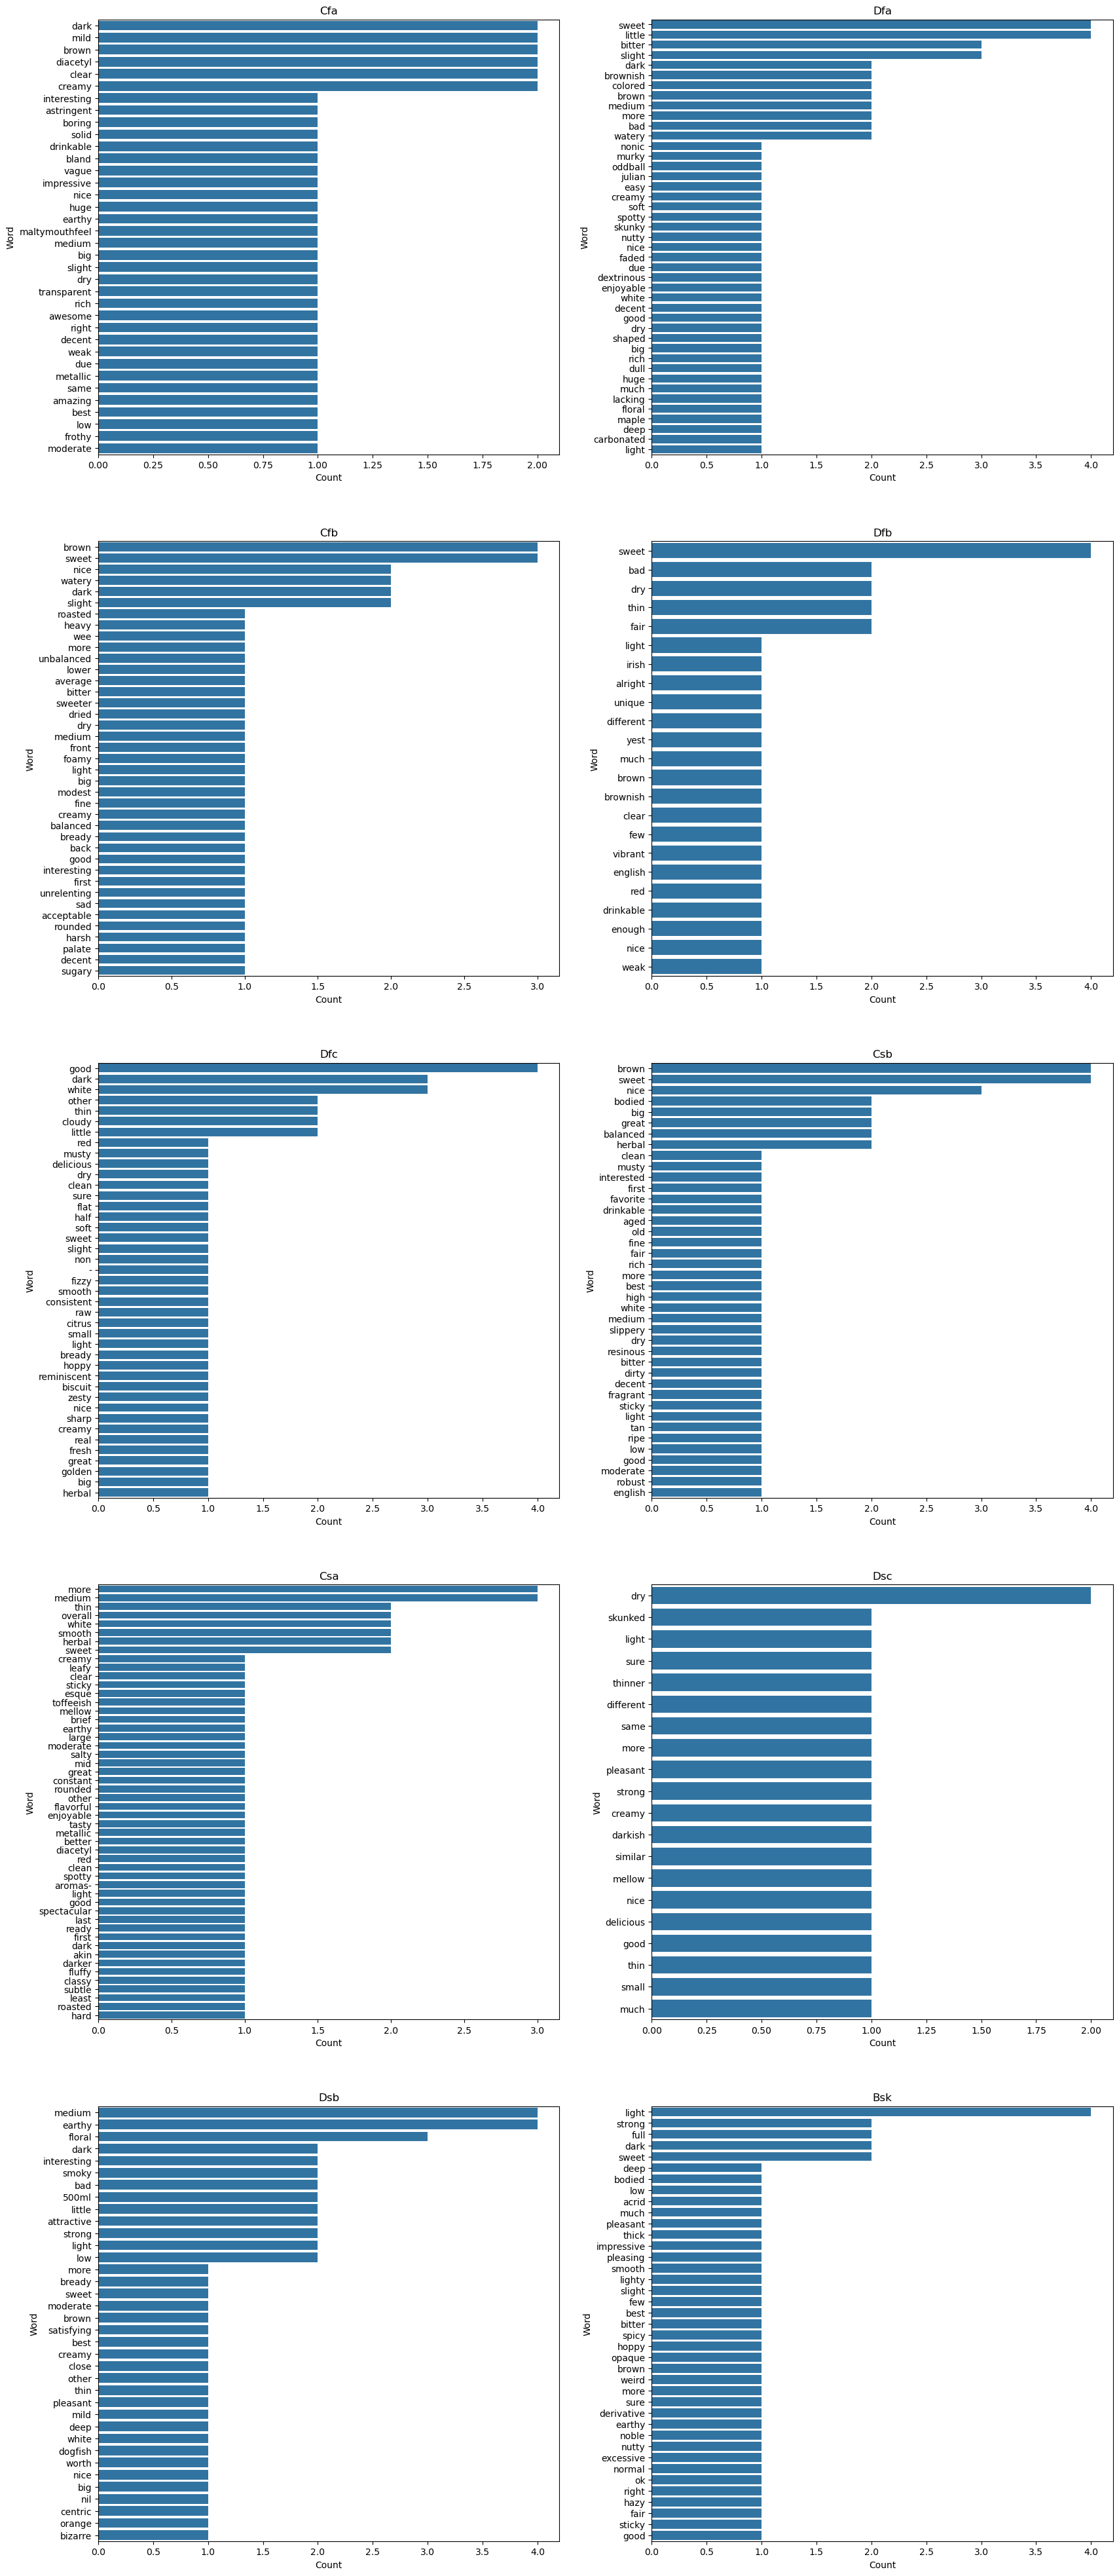

In [19]:
#plot counts of the 50 most common words for each climate
fig, axs = plt.subplots(5, 2, figsize=(20, 50))

for i in range(len(climates)):
    sns.barplot(y=counts_climate[i][:50].index, x=counts_climate[i][:50].values, ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title(climates[i])
    axs[i//2, i%2].set_xlabel("Count")
    axs[i//2, i%2].set_ylabel("Word")


In [ ]:
schemes = us_users_txt_rev["scheme"].unique()

adj_scheme = [[]]*len(schemes)
for i in trange(len(schemes)):
    us_users_txt_rev_scheme = us_users_txt_rev[us_users_txt_rev["scheme"]==schemes[i]]
    for j in range(len(us_users_txt_rev_scheme)):        
        adj_scheme[i] += us_users_txt_rev_scheme["adj"].iloc[j]


In [ ]:
temperature = us_users_txt_rev["heat_level"].unique()

adj_temperature = [[]]*len(temperature)
for i in trange(len(temperature)):
    us_users_txt_rev_temperature = us_users_txt_rev[us_users_txt_rev["heat_level"]==temperature[i]]
    for j in range(len(us_users_txt_rev_temperature)):        
        adj_temperature[i] += us_users_txt_rev_temperature["adj"].iloc[j]


In [ ]:

precipitation = us_users_txt_rev["seasonal_precipitation"].unique()

adj_precipitation = [[]]*len(precipitation)
for i in trange(len(precipitation)):
    us_users_txt_rev_precipitation = us_users_txt_rev[us_users_txt_rev["seasonal_precipitation"]==precipitation[i]]
    for j in range(len(us_users_txt_rev_precipitation)):        
        adj_precipitation[i] += us_users_txt_rev_precipitation["adj"].iloc[j]

sweet         230340
light         229057
white         226708
nice          209233
good          190869
               ...  
^sour              1
gueueze            1
earhtyy            1
03.03.07           1
meloncholy         1
Name: count, Length: 39151, dtype: int64

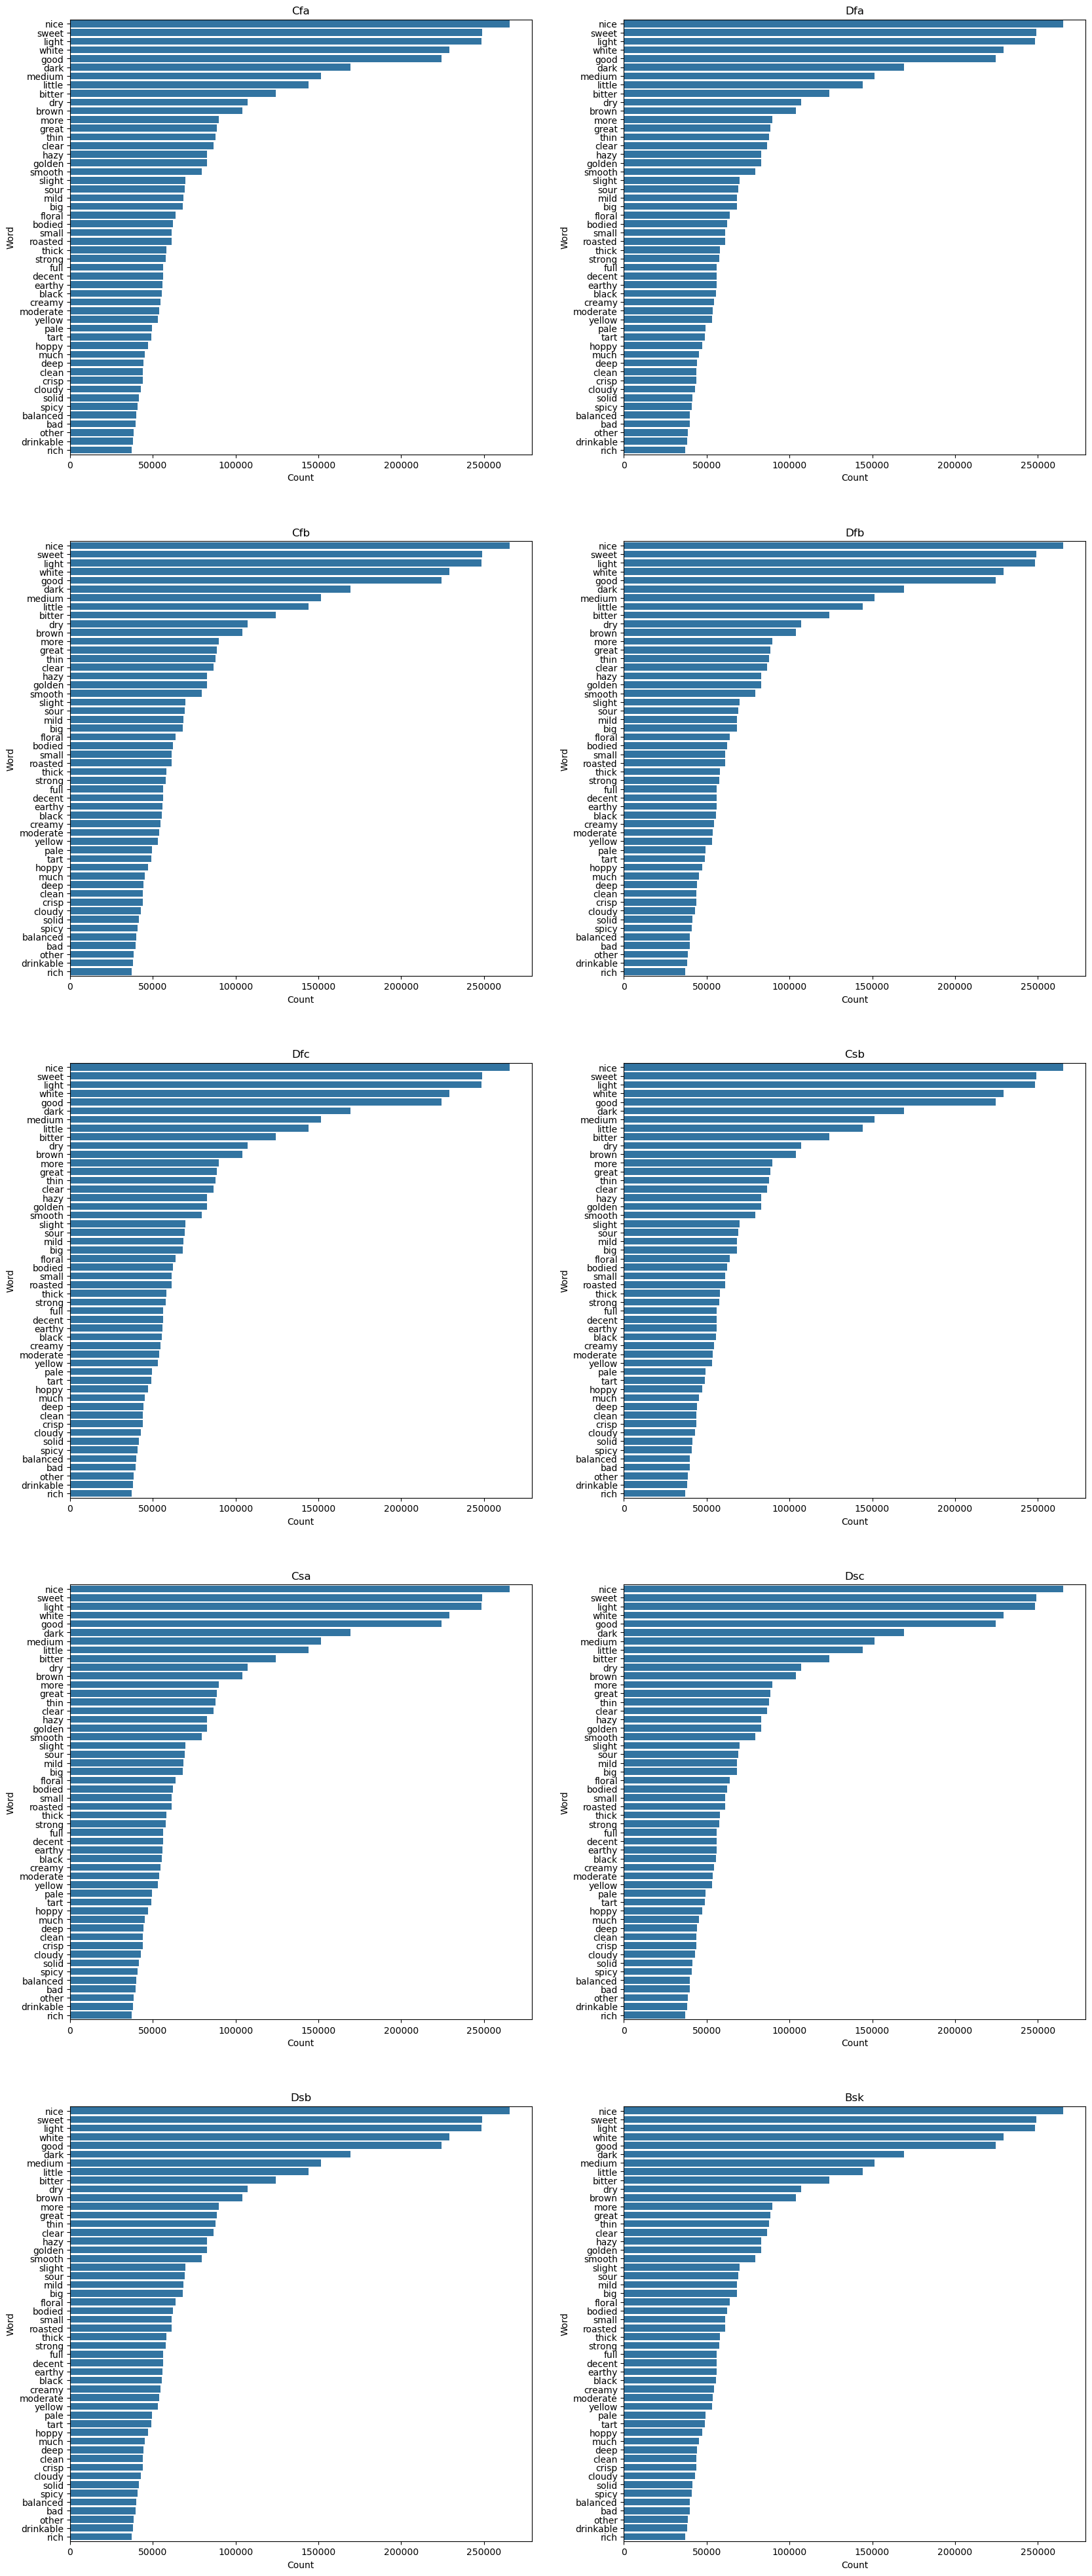

In [20]:

#plot counts of the 50 most common words for each climate
fig, axs = plt.subplots(5, 2, figsize=(20, 50))

for i in range(len(climates)):
    sns.barplot(y=counts_climate[i][:50].index, x=counts_climate[i][:50].values, ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title(climates[i])
    axs[i//2, i%2].set_xlabel("Count")
    axs[i//2, i%2].set_ylabel("Word")


In [ ]:
unique_adj_climate = [list(counts_climate[i].index) for i in range(len(counts_climate))]

In [ ]:
#delete so free RAM
del adj_climate

In [ ]:
adj_scheme = [[word.lower() for word in adj_scheme[i]] for i in range(len(adj_scheme))]

In [ ]:
#delete so free RAM
del adj_scheme

In [ ]:
adj_temperature = [[word.lower() for word in adj_temperature[i]] for i in range(len(adj_temperature))]


In [ ]:
#delete so free RAM
del adj_temperature

In [ ]:
adj_precipitation = [[word.lower() for word in adj_precipitation[i]] for i in range(len(adj_precipitation))]
